# Necessary imports

In [75]:
import mediapipe as mp
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import os
import shutil
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(42)

# Helper functions

In [2]:
# Create a Holistic object to detect pose, face, and hands keypoints
mp_holistic = mp.solutions.holistic

# Drawing utilities
mp_drawing = mp.solutions.drawing_utils 

In [3]:
def mediapipe_detection(image, model):
  """ Takes an input image and a MediaPipe model, and applies the model to the 
  image using the MediaPipe library for object detection or pose estimation.
  Args:
    image(numpy.ndarray): a frame of our video
    model(mediapipe.python.solutions.holistic.Holistic): the mediapipe model of choice
  Returns:
    image(numpy.ndarray): The processed image in BGR format. It can be used to display the input image with any detected objects
    or keypoints overlaid on top.
    results(mediapipe.python.solution_base.SolutionOutputs): contains the detected landmarks for the face, pose, left hand and 
    right hand in an image or a video frame.
  """
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
  image.flags.writeable = False                  # Image is no longer writeable
  results = model.process(image)                 # Make prediction
  image.flags.writeable = True                   # Image is now writeable 
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
  return image, results

In [4]:
def draw_styled_landmarks(image, results):
    """The function uses the mp_drawing module from MediaPipe to draw stylized connections between the detected landmarks onto the input image.
    Args:
      image(numpy.ndarray): The processed image returned from the mediapipe_detection function.
      results(mediapipe.python.solution_base.SolutionOutputs): contains the landmarks for the face, pose, left hand and 
      right hand in an image or a video frame detected by the model.
    """
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
def adjust_landmarks(arr,center):
    """
    Adjusts the array to make the landmarks in the array relative to the center.
    
    Args:
        arr (numpy.ndarray): The input array of landmarks with shape (n*3,).
        center (numpy.ndarray): The center array with shape (3,) to be subtracted from arr.

    Returns:
        numpy.ndarray: The adjusted array of landmarks with shape (n*3,).

    """
    # Reshape the array to have shape (n, 3)
    arr_reshaped = arr.reshape(-1, 3)

    # Repeat the center array to have shape (n, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))

    # Subtract the center array from the arr array
    arr_adjusted = arr_reshaped - center_repeated

    # Reshape arr_adjusted back to shape (n*3,)
    arr_adjusted = arr_adjusted.reshape(-1)
    return(arr_adjusted)

In [6]:
def extract_keypoints(results):
    """
    Extracts keypoints from the input results object and adjusts them to make them relative to specific landmarks.

    Args:
        results: The results object containing pose and hand landmarks.

    Returns:
        tuple: A tuple containing the adjusted pose keypoints, left hand keypoints, and right hand keypoints.
        
    Notes:
        - The pose keypoints are represented as a numpy.ndarray with shape (33*3,).
        - The left hand keypoints are represented as a numpy.ndarray with shape (21*3,).
        - The right hand keypoints are represented as a numpy.ndarray with shape (21*3,).
    """
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    nose=pose[:3]
    lh_wrist=lh[:3]
    rh_wrist=rh[:3]
    pose_adjusted = adjust_landmarks(pose,nose)
    lh_adjusted = adjust_landmarks(lh,lh_wrist)
    rh_adjusted = adjust_landmarks(rh,rh_wrist)
    return pose_adjusted, lh_adjusted, rh_adjusted

# Reading our labels

In [7]:
karsl_df = pd.read_excel('KARSL-502_Labels.xlsx')
karsl_100 = karsl_df[70:170].reset_index(drop=True)
karsl_100

,SignID,Sign-Arabic,Sign-English
0,71,هيكل عظمي,Skeleton
1,72,جمجة,skull
2,73,عمود فقري,Backbone
3,74,قفص صدري,Chest
4,75,جهاز تنفسي,Respiratory device
...,...,...,...
95,166,يشم,inhale
96,167,يصعد,rise
97,168,ينزل,descend
98,169,يفتح,open


# Create Labels

In [8]:
words= np.array([v for v in karsl_100['Sign-Arabic']])
print(words)

['هيكل عظمي' 'جمجة' 'عمود فقري' 'قفص صدري' 'جهاز تنفسي' 'قصبة هوائية'
 'رئتان' 'شهيق - زفير' 'جهاز هضمي' 'وجه' 'بلعوم' 'كبد' 'البنكرياس'
 'الأمعاء الدقيقة' 'الأمعاء الغليظة' 'الزائدة الدودية' 'جهاز عصبي' 'قلب'
 'حواس خمس' 'عضلة' 'أنسجة' 'مستشفى' 'إسعافات أولية' 'جرح نازف' 'حروق'
 'مخدر/ بنج' 'عملية جراحية' 'شاش / ضمادة' 'شريط لاصق / بلاستر' 'صيدلية'
 'تحليل دم' 'فحص سريري' 'فحص النظر' 'ميزان حرارة' 'سماعة أذن'
 'جهاز قياس الضغط' 'نبض القلب' 'تحليل طبي' 'معمل التحاليل / مختبر'
 'صورة اشعة' 'التهاب' 'تورم' 'زكام' 'عدوى' 'صداع' 'ألم' 'حمى' 'إسهال'
 'إمساك' 'مغص' 'مرض السكر / سكري' 'أزمة قلبية' 'سرطان'
 'مرض فقدان المناعة / الإيدز' 'تساقط الشعر' 'سكتة قلبية' 'شلل نصفي'
 'شلل دماغي' 'ضغط الدم' 'حساسية' 'حكة / هرش' 'دواء' 'دورة شهرية'
 'مريض / مرض' 'كبسولة' 'دواء شراب' 'مرهم' 'قطارة' 'أخذ إبرة' 'تلقيح'
 'تطعيم' 'أشعة ليزر' 'مخدرات' 'إدمان' 'توحد / أوتيزم' 'منغولي' 'بكتريا'
 'جرثومة' 'فيروس' 'إنتشار' 'إعاقة' 'إعاقة ذهنية' 'اعاقة جسدية'
 'اعاقة بصرية' 'إعاقة سمعية' 'وباء' 'مناعة' 'عصب' 'معافى'

In [9]:
label_map = {label:num for num, label in enumerate(words)}
print(label_map)

{'هيكل عظمي': 0, 'جمجة': 1, 'عمود فقري': 2, 'قفص صدري': 3, 'جهاز تنفسي': 4, 'قصبة هوائية': 5, 'رئتان': 6, 'شهيق - زفير': 7, 'جهاز هضمي': 8, 'وجه': 9, 'بلعوم': 10, 'كبد': 11, 'البنكرياس': 12, 'الأمعاء الدقيقة': 13, 'الأمعاء الغليظة': 14, 'الزائدة الدودية': 15, 'جهاز عصبي': 16, 'قلب': 17, 'حواس خمس': 18, 'عضلة': 19, 'أنسجة': 20, 'مستشفى': 21, 'إسعافات أولية': 22, 'جرح نازف': 23, 'حروق': 24, 'مخدر/ بنج': 25, 'عملية جراحية': 26, 'شاش / ضمادة': 27, 'شريط لاصق / بلاستر': 28, 'صيدلية': 29, 'تحليل دم': 30, 'فحص سريري': 31, 'فحص النظر': 32, 'ميزان حرارة': 33, 'سماعة أذن': 34, 'جهاز قياس الضغط': 35, 'نبض القلب': 36, 'تحليل طبي': 37, 'معمل التحاليل / مختبر': 38, 'صورة اشعة': 39, 'التهاب': 40, 'تورم': 41, 'زكام': 42, 'عدوى': 43, 'صداع': 44, 'ألم': 45, 'حمى': 46, 'إسهال': 47, 'إمساك': 48, 'مغص': 49, 'مرض السكر / سكري': 50, 'أزمة قلبية': 51, 'سرطان': 52, 'مرض فقدان المناعة / الإيدز': 53, 'تساقط الشعر': 54, 'سكتة قلبية': 55, 'شلل نصفي': 56, 'شلل دماغي': 57, 'ضغط الدم': 58, 'حساسية': 59, 'حكة / هرش': 

# Preprocess Data : using a fixed number of frames

In [10]:
def preprocess_data(signers,split,f_avg):
    """"
    This function loads the keypoints arrays for each video sequence of each word performed by the given signers, and extracts 
    a subsequence of length 'f_avg' from each sequence. Then it converts the sequences and labels to numpy arrays and returns 
    them as X and y.
    
    Args:
        signers(list): the signers of interest.
        split(str): can be 'train' or 'test'.
        f_avg(int): threshold for frame sampling.
    
    Returns:
        X(numpy.ndarray): array of sequences
        y(numpy.ndarray): array of one-hot encoded sign labels
    """

    # Initialize the lists of sequences and labels
    sequences, labels = [], []

    # Iterate through the list of words
    for word in tqdm(words):
        for signer in signers:
            # Iterate through the numpy arrays contained in the directory mentioned below
            for sequence in os.listdir(os.path.join(str(signer), split, str(label_map[word] + 71).zfill(4), 'lh_keypoints')):

                # Load the left hand array
                res_lh = np.load(os.path.join(str(signer), split, str(label_map[word] + 71).zfill(4), 'lh_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_lh.shape[0], f_avg)
                res_lh = res_lh[:num_frames,:]
                while num_frames < f_avg:
                    res_lh = np.concatenate((res_lh, np.expand_dims(res_lh[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Load the right hand array
                res_rh = np.load(os.path.join(str(signer), split, str(label_map[word] + 71).zfill(4), 'rh_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_rh.shape[0], f_avg)
                res_rh = res_rh[:num_frames,:]
                while num_frames < f_avg:
                    res_rh = np.concatenate((res_rh, np.expand_dims(res_rh[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Load the pose array
                res_pose = np.load(os.path.join(str(signer), split, str(label_map[word] + 71).zfill(4), 'pose_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_pose.shape[0], f_avg)
                res_pose = res_pose[:num_frames,:]
                while num_frames < f_avg:
                    res_pose = np.concatenate((res_pose, np.expand_dims(res_pose[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Append the subsequence to the list of sequences
                sequences.append(np.concatenate((res_pose,res_lh, res_rh), axis=1))
                # Append the label to the list of labels
                labels.append(label_map[word])

    # Convert the lists of sequences and labels to numpy arrays
    X = np.array(sequences)
    y = to_categorical(labels).astype(int)

    return X, y

In [11]:
#train and validation splits
X_train,y_train=preprocess_data([1,2,3],'train',48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [52:09<00:00, 31.29s/it]


(10173, 48, 225)
(10173, 100)
(2544, 48, 225)
(2544, 100)


In [12]:
#test split
X_test,y_test=preprocess_data([1,2,3],'test',48)
print(X_test.shape)
print(y_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:57<00:00,  7.17s/it]

(2400, 48, 225)
(2400, 100)


# Build and Train BiLSTM Neural Network


In [13]:
# Define the Bidirectional LSTM model with Attention
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(words), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    mode='min',  # Set mode to 'min' for minimizing the metric
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

In [14]:
# Train the model on the holistic keypoints features and labels
model_training_history = model.fit(X_train, y_train, batch_size=32, validation_data=(X_val,y_val), validation_batch_size=32, epochs=50, callbacks=[early_stopping])

Epoch 1/50
318/318 [==============================] - 232s 175ms/step - loss: 3.1853 - categorical_accuracy: 0.2166 - val_loss: 1.6563 - val_categorical_accuracy: 0.5428
Epoch 2/50
318/318 [==============================] - 109s 343ms/step - loss: 1.1019 - categorical_accuracy: 0.6836 - val_loss: 0.6826 - val_categorical_accuracy: 0.8113
Epoch 3/50
318/318 [==============================] - 44s 137ms/step - loss: 0.4650 - categorical_accuracy: 0.8771 - val_loss: 0.3174 - val_categorical_accuracy: 0.9218
Epoch 4/50
318/318 [==============================] - 47s 148ms/step - loss: 0.2764 - categorical_accuracy: 0.9336 - val_loss: 0.1468 - val_categorical_accuracy: 0.9709
Epoch 5/50
318/318 [==============================] - 49s 154ms/step - loss: 0.1244 - categorical_accuracy: 0.9756 - val_loss: 0.0847 - val_categorical_accuracy: 0.9858
Epoch 6/50
318/318 [==============================] - 48s 150ms/step - loss: 0.1209 - categorical_accuracy: 0.9717 - val_loss: 0.1567 - val_categorical_a

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 48, 128)          148480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 100)               3300      
                                                                 
Total params: 254,724
Trainable params: 254,724
Non-trainable params: 0
_________________________________________________________________


# Evaluate the model

In [16]:
# Evaluate the model on train data
model_evaluation_history = model.evaluate(X_train, y_train)

318/318 [==============================] - 13s 39ms/step - loss: 0.0016 - categorical_accuracy: 1.0000


In [17]:
# Evaluate the model on test data
model_evaluation_history = model.evaluate(X_test, y_test)

75/75 [==============================] - 3s 35ms/step - loss: 0.0262 - categorical_accuracy: 0.9962


# Plot Model’s Loss & Accuracy Curves

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

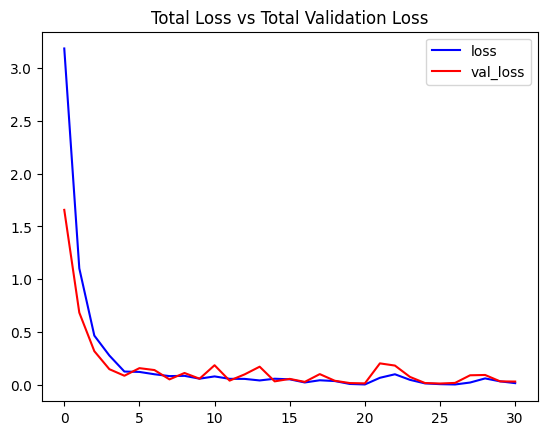

In [19]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

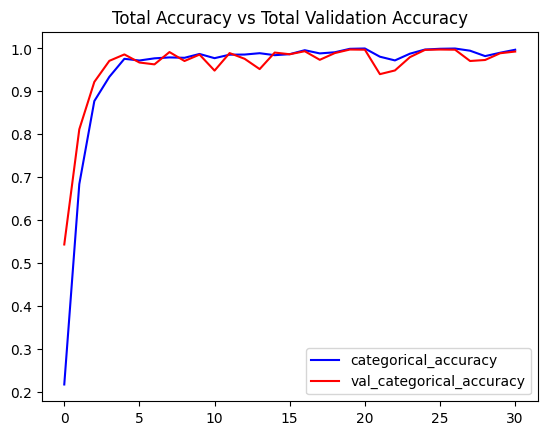

In [20]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Make Predictions

In [21]:
#Predicted sign
res = model.predict(X_test)
words[np.argmax(res[500])]

75/75 [==============================] - 471s 33ms/step


'أنسجة'

In [22]:
#Real sign
words[np.argmax(y_test[500])]

'أنسجة'

# Save weights

In [23]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'Holistic_keypoints_BiLSTM_model_3_signers___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
model.save(model_file_name)

# Evaluation using Confusion Matrix

In [77]:
yhat = model.predict(X_test)

75/75 [==============================] - 6s 41ms/step


In [78]:
def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None

In [79]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [80]:
y = []
for v in ytrue:
    y.append(get_key_by_value(label_map, v))
print(y)

['هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قف

In [81]:
y = [karsl_100[karsl_100['Sign-Arabic'] == v]['Sign-English'].values[0] for v in y]
print(y)

['Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 

In [82]:
ypred = []
for v in yhat:
    ypred.append(get_key_by_value(label_map, v))
print(ypred)

['هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'هيكل عظمي', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'جمجة', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'عمود فقري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قفص صدري', 'قف

In [83]:
ypred = [karsl_100[karsl_100['Sign-Arabic'] == v]['Sign-English'].values[0] for v in ypred]
print(ypred)

['Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'Skeleton', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'skull', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Backbone', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 'Chest', 

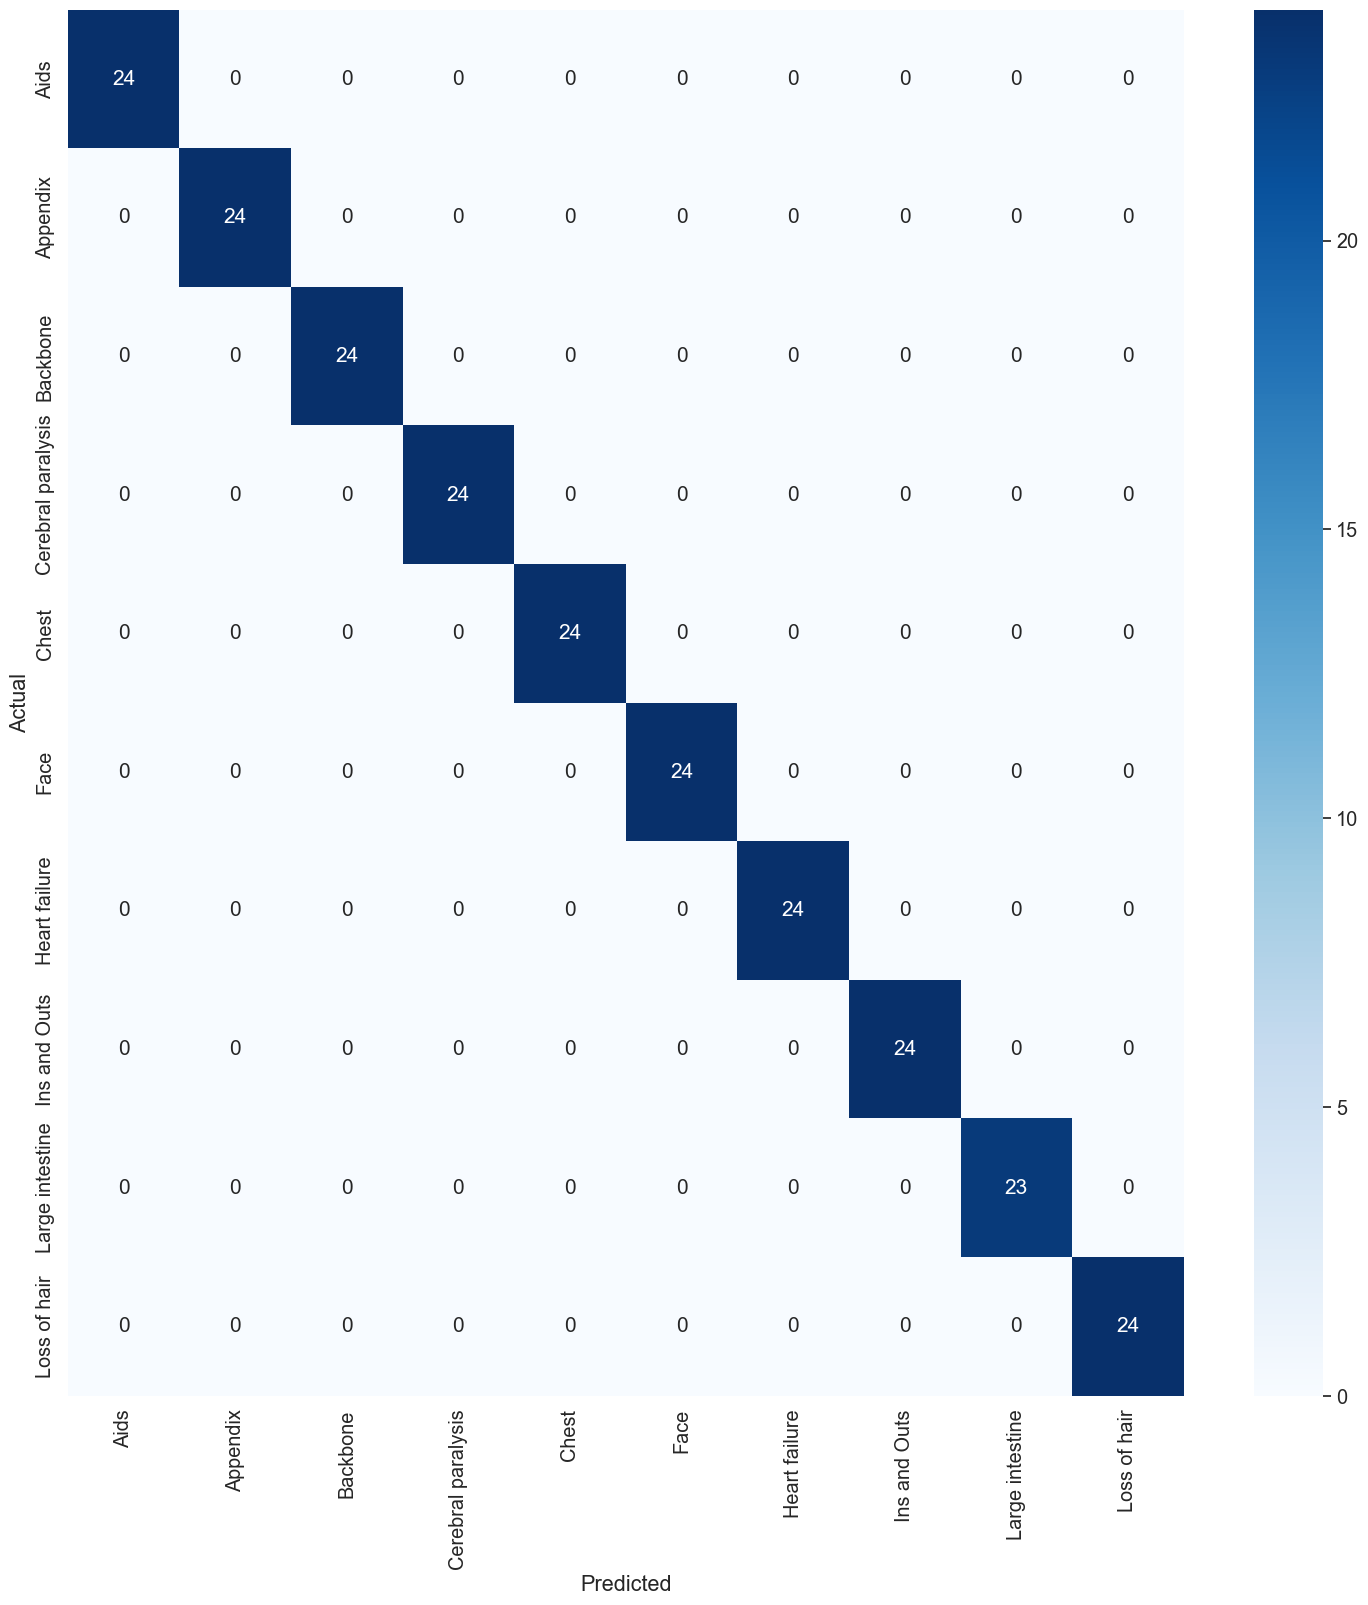

In [86]:
#Confusion matrix for the first 10 classes
data = confusion_matrix(y, ypred)[:10,:10]
df_cm = pd.DataFrame(data, columns=np.unique(y)[:10], index = np.unique(y)[:10])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (18,18))
sns.set(font_scale=1.3)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 15})
plt.show()

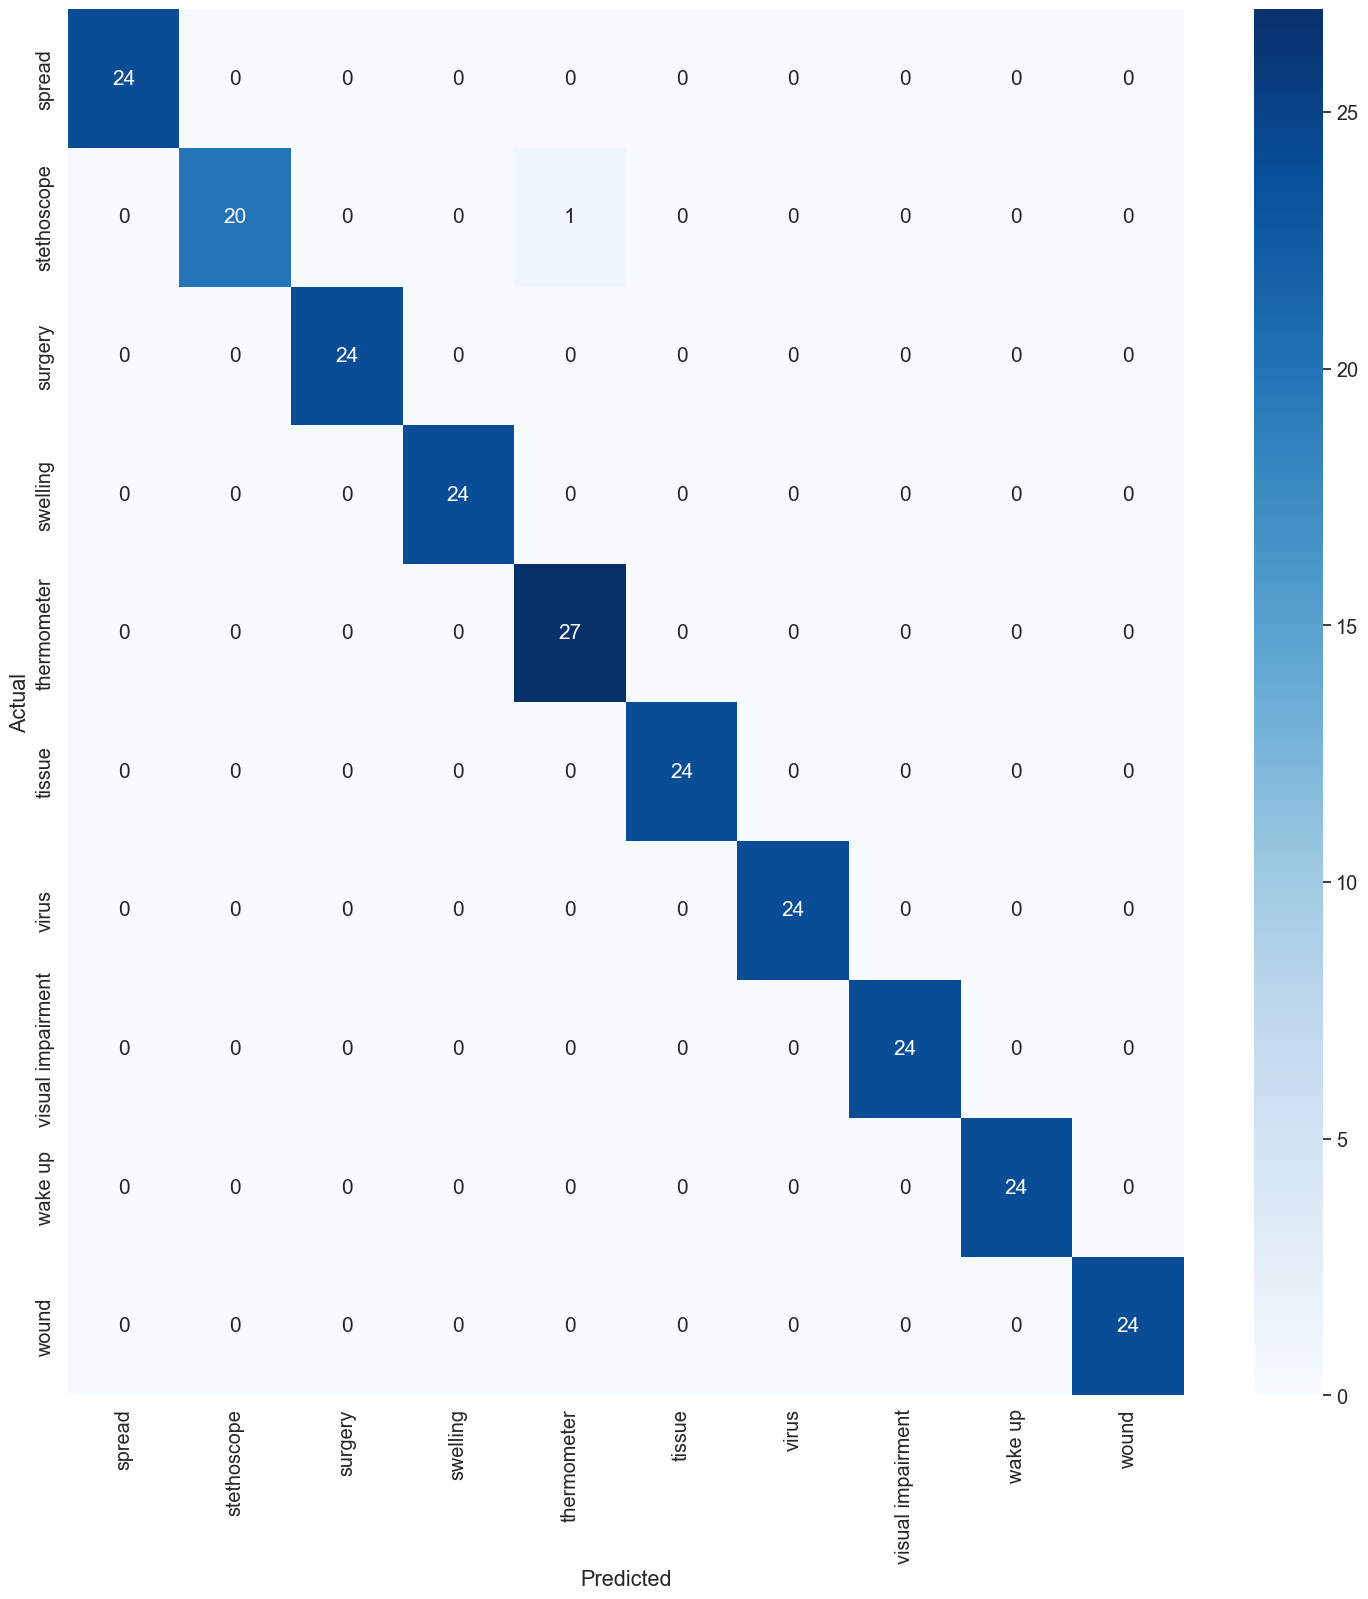

In [87]:
#Confusion matrix for the last 10 classes
data = confusion_matrix(y, ypred)[-10:,-10:]
df_cm = pd.DataFrame(data, columns=np.unique(y)[-10:], index = np.unique(y)[-10:])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (18,18))
sns.set(font_scale=1.3)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 15})
plt.show()

# Test on our videos

In [84]:
def predict_sign(video_path, f_avg):
    """
    Predicts a sign gesture from a video file using the Mediapipe Holistic model.

    Args:
        video_path (str): The path to the video file.
        f_avg (int): The number of frames to make prediction from.
    """
    
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Check if the video file was successfully opened
    if not video.isOpened():
      print('Could not open video file')
    else:
      # Initialize the list of keypoints for this video
      pose_keypoints, lh_keypoints, rh_keypoints = [], [], []
      # Initialize the Mediapipe Holistic model
      with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

        # Loop through the video frames
        while True:
          # Read the next frame
          ret, frame = video.read()

          # Check if there are no more frames to read
          if not ret:
            break

          # Make detections
          image, results = mediapipe_detection(frame, holistic)

          # Extract keypoints
          pose, lh, rh = extract_keypoints(results)
          # Add the keypoints to the list for this video
          pose_keypoints.append(pose)
          lh_keypoints.append(lh)
          rh_keypoints.append(rh)

      # Release the video file
      video.release() 

    holistic_keypoints = np.concatenate((pose_keypoints, lh_keypoints, rh_keypoints), axis=1)

    # Determine how many rows to select
    num_frames = min(holistic_keypoints.shape[0], f_avg)
    holistic_keypoints = holistic_keypoints[:num_frames,:]
    while num_frames < f_avg:
      holistic_keypoints = np.concatenate((holistic_keypoints, np.expand_dims(holistic_keypoints[-1,:], axis=0)), axis=0)
      num_frames += 1

    #predicted sign
    res = model.predict(np.expand_dims(holistic_keypoints, axis=0))[0]
    print(words[np.argmax(res)])

In [87]:
predict_sign('skeleton.mp4', 48)

1/1 [==============================] - 0s 28ms/step
هيكل عظمي


In [88]:
predict_sign('heart.mp4', 48)

1/1 [==============================] - 0s 28ms/step
قلب
